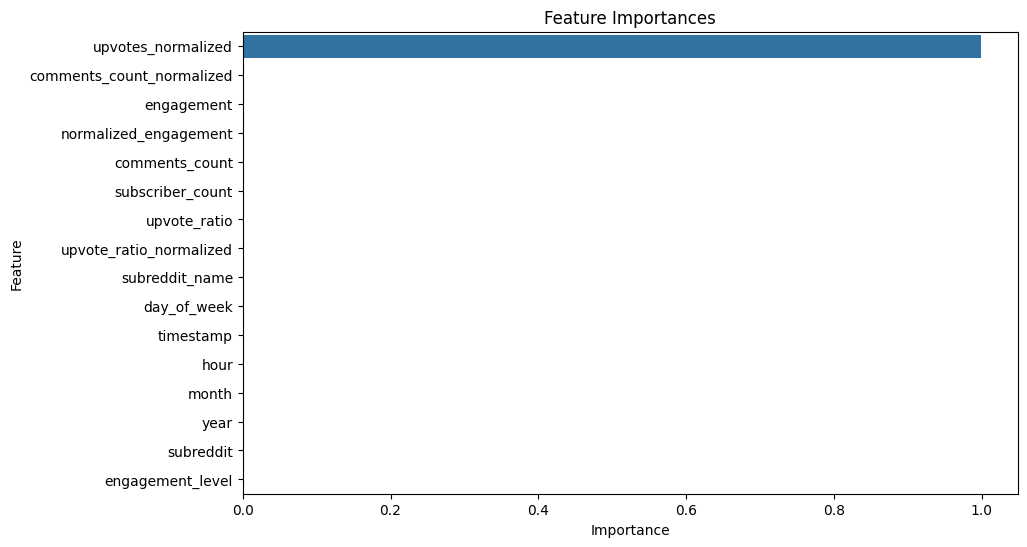

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate the model using MAE and R-squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')


Mean Absolute Error: 2.1377413224302275
R-squared: 0.999070745869197


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import randint

# Load your dataset
df = pd.read_csv('labeled_subreddit_posts.csv')

# Convert the 'timestamp' column to a datetime type and then extract new features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['timestamp'] = df['timestamp'].astype(int) / 10**9  # Convert to Unix timestamp

# Handle missing values using median imputation
imputer = SimpleImputer(strategy='median')  # Use median imputation for numerical columns
df['subscriber_count'] = imputer.fit_transform(df[['subscriber_count']])

# Encode categorical columns
label_encoder = LabelEncoder()
df['subreddit_name'] = label_encoder.fit_transform(df['subreddit_name'].fillna('Unknown'))

# Drop other non-numeric columns that aren't necessary for modeling
df = df.drop(columns=['title', 'content', 'author', 'post_id', 'date', 'time', 'AM_PM'])

# Select features (X) and target variable (y)
X = df.drop(columns=['upvotes'])  # Features
y = df['upvotes']  # Target variable

# Convert all columns to numeric (if they are not already)
X = X.apply(pd.to_numeric, errors='coerce')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (RandomForestRegressor)
model = RandomForestRegressor(n_jobs=-1, random_state=42)

# Define hyperparameters to tune
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the model using randomized search
random_search.fit(X_train, y_train)

# Best model from random search
best_model = random_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Cross-validation for more robust performance estimation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')

# Optionally, print out predictions versus actual values for further inspection
print(f'Predicted upvotes: {y_pred[:5]}')
print(f'Actual upvotes: {y_test[:5].values}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean Squared Error: 1152.583717589293
Cross-validated MSE: 10065.371559795014
Predicted upvotes: [5.00000000e+00 1.00000000e+00 2.96571186e+03 5.30000000e+01
 1.00000000e+00]
Actual upvotes: [   5    1 2963   53    1]


In [17]:
# Assuming you have already split your dataset into training and testing data as `X_train`, `X_test`, `y_train`, `y_test`

# Use the best model from grid search to predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test data
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'Test Mean Squared Error: {test_mse}')

# Calculate R-squared on the test data
test_r2 = best_model.score(X_test, y_test)
print(f'Test R-squared: {test_r2}')

# Calculate Mean Absolute Error (MAE) on the test data
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test Mean Absolute Error: {test_mae}')

# Optionally, print out some predictions versus actual values to inspect the results
print(f'Predicted upvotes (Test set): {y_test_pred[:5]}')
print(f'Actual upvotes (Test set): {y_test[:5].values}')


Test Mean Squared Error: 1152.583717589293
Test R-squared: 0.999070745869197
Test Mean Absolute Error: 2.1377413224302275
Predicted upvotes (Test set): [5.00000000e+00 1.00000000e+00 2.96571186e+03 5.30000000e+01
 1.00000000e+00]
Actual upvotes (Test set): [   5    1 2963   53    1]
